# decision tree 
(best test accuracy: 0.85, depth 5)

In [3]:
import pandas as pd
import sklearn
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
rs = np.random.RandomState(123)

df = pd.read_csv('diabetes.csv')
df.info() # all numbers, yay!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df = df.dropna()
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.3, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_, y_, test_size=0.6, shuffle=True)
#df.shape => (768, 9); you should know this already though from .info()

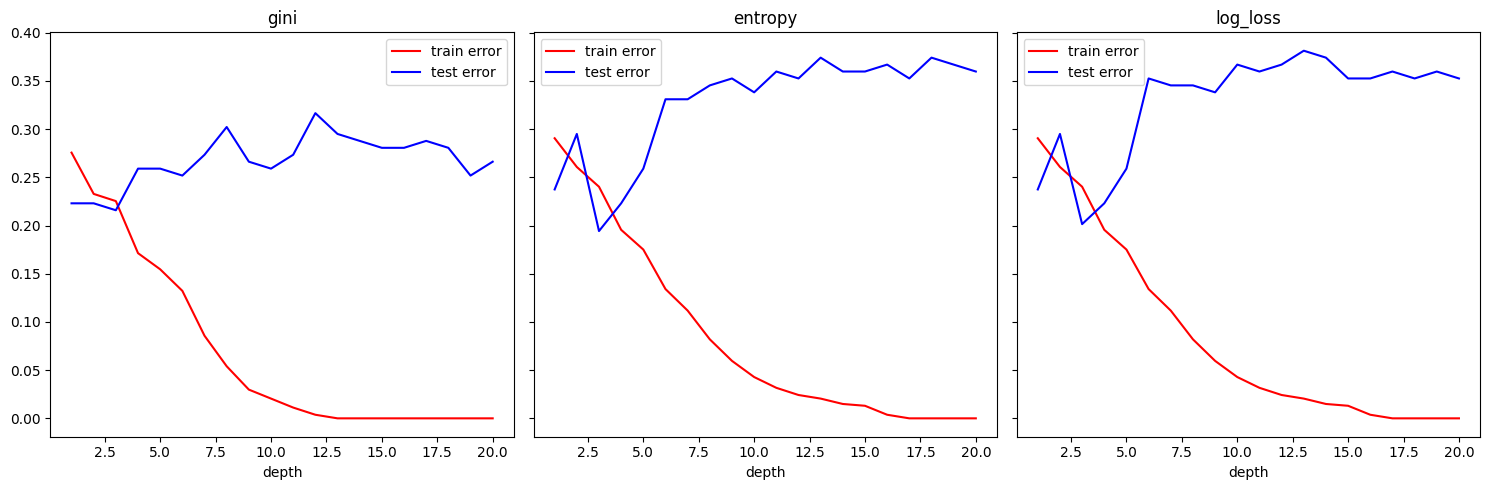

In [6]:
from sklearn.metrics import accuracy_score, log_loss
N = 20 # depth

criterions = ['gini', 'entropy', 'log_loss']

fig, axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
for ax,c in zip(axs, criterions):
    train_errs = np.empty(N)
    test_errs = np.empty(N)
    for d in range(N):
        model = DecisionTreeClassifier(max_depth=d+1, criterion=c)
        model.fit(X_train, y_train)
    
        train_errs[d] = 1-accuracy_score(y_train, model.predict(X_train))
        test_errs[d] = 1-accuracy_score(y_test, model.predict(X_test))

    ds = np.linspace(1,N, N)
    ax.plot(ds, train_errs, color='red', label='train error')
    ax.plot(ds, test_errs, color='blue', label='test error')
    ax.set_xlabel("depth")
    ax.set_title("{}".format(c))
    ax.legend()

plt.tight_layout()
plt.show() # clearly overfitting.

Train Accuracy: 0.7616387337057728
Test Accuracy: 0.7985611510791367


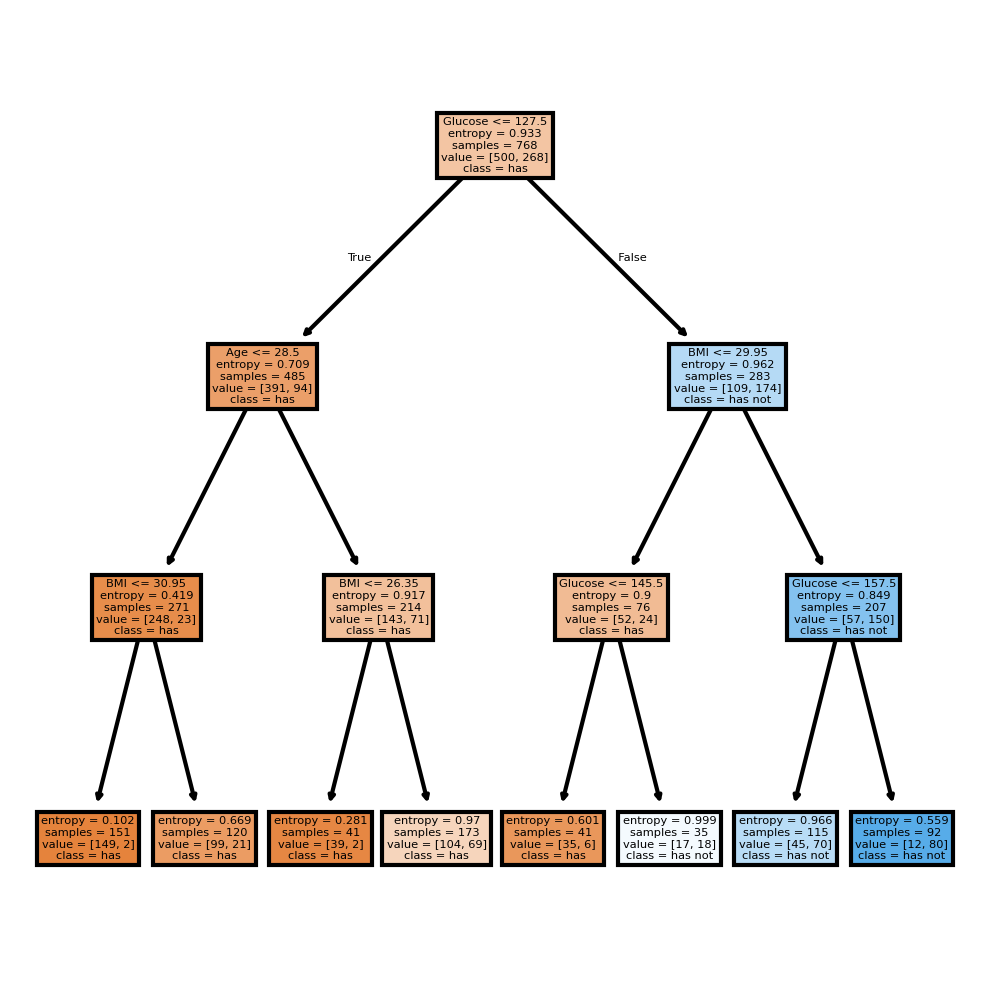

In [9]:
fnames = df.columns[:-1].to_list()
tname = df.columns[-1]
dt_mod = DecisionTreeClassifier(max_depth = 3, criterion='entropy').fit(X,y)
fig, axes = plt.subplots(1,1, figsize=(4,4), dpi=300)
tree.plot_tree(dt_mod, feature_names=fnames, class_names=['has', 'has not'], filled=True)
print(f'Train Accuracy: {accuracy_score(dt_mod.predict(X_train), y_train)}')
print(f'Test Accuracy: {accuracy_score(dt_mod.predict(X_test), y_test)}')
plt.show()
#depth 5:
#Train Accuracy: 0.8305400372439479
#Test Accuracy: 0.8561151079136691

# logistic regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Train final model
logistic_mod = LogisticRegression(penalty='l2', solver='liblinear').fit(X_train, y_train)

print(f'Train Accuracy: {accuracy_score(logistic_mod.predict(X_train), y_train)}')
print(f'Test Accuracy: {accuracy_score(logistic_mod.predict(X_test), y_test)}')

Train Accuracy: 0.7653631284916201
Test Accuracy: 0.7553956834532374


## grid search

In [20]:
#param_grid = {'C': np.logspace(-3, 3, 7)} #start your 'binary-search' of sorts with this.
param_grid = {'C': np.linspace(0.00001,3,100)}

"""l1:
Best C according to gridsearch: 11.161616161616163
Train Accuracy: 0.7728119180633147
Test Accuracy: 0.7482014388489209
"""

grid_lr = GridSearchCV(estimator=LogisticRegression(penalty='l1', solver='liblinear'),
                       cv=None, 
                       param_grid=param_grid, 
                       scoring='neg_log_loss')
grid_lr.fit(X_valid, y_valid)
Cbest = grid_lr.best_params_['C']
print(f'Best C according to gridsearch: {Cbest}')

logistic_mod = LogisticRegression(penalty='l1',  solver='liblinear', C=Cbest).fit(X_train, y_train)
print(f'Train Accuracy: {accuracy_score(logistic_mod.predict(X_train), y_train)}')
print(f'Test Accuracy: {accuracy_score(logistic_mod.predict(X_test), y_test)}')


Best C according to gridsearch: 1.2727330303030302
Train Accuracy: 0.770949720670391
Test Accuracy: 0.7553956834532374


# SVM

In [22]:
from sklearn import svm

param_grid = {'C': np.logspace(-3, 3, 7)}  # [0.001, 0.01, 0.1, 1, 10, 100, 1000]

models = [
    ("SVC with linear kernel", svm.SVC(kernel="linear")),
    ("SVC with RBF kernel", svm.SVC(kernel="rbf", gamma=0.7)),
    ("SVC with polynomial (degree 2)", svm.SVC(kernel="poly", degree=2, gamma="auto"))
]

print("Grid Search Results for Optimal C:\n")
for name, model in models:
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    
    grid_search.fit(X_valid, y_valid)
    
    best_model = grid_search.best_estimator_
    best_C = grid_search.best_params_['C']
    best_cv_score = grid_search.best_score_
    
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    print(f"{name}")
    print(f"  Optimal C: {best_C}")
    print(f"  Best Cross-Validation Score: {best_cv_score:.3f}")
    print(f"  Test Accuracy: {test_accuracy:.3f}\n")


Grid Search Results for Optimal C:

SVC with linear kernel
  Optimal C: 0.01
  Best Cross-Validation Score: 0.771
  Test Accuracy: 0.755

SVC with RBF kernel
  Optimal C: 0.001
  Best Cross-Validation Score: 0.663
  Test Accuracy: 0.597

SVC with polynomial (degree 2)
  Optimal C: 10.0
  Best Cross-Validation Score: 0.761
  Test Accuracy: 0.662

